In [2]:
import os
import obspy.clients.fdsn
import numpy as np
import pandas as pd
import obspy
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from datetime import datetime
import scipy
import warnings
warnings.filterwarnings("ignore")

# Area based event search

In [4]:
client = "IRIS"

# dates to request data for
starttime = obspy.UTCDateTime("2010-10-31T00:00:00")
endtime = obspy.UTCDateTime("2012-02-09T23:59:59")

# define map extent
minlatitude = 33.16
maxlatitude = 38.0
minlongitude = -103.16
maxlongitude = -94.35

# min and max requested magnitudes
minmagnitude = 2
maxmagnitude = 9

client = obspy.clients.fdsn.Client(client)

events = client.get_events(minlatitude=minlatitude, maxlatitude=maxlatitude,
                           minlongitude=minlongitude, maxlongitude=maxlongitude,
                           starttime=starttime,
                           endtime=endtime,
                           minmagnitude=minmagnitude,maxmagnitude=maxmagnitude)

print("found %s event(s):" % len(events))
print(events)

found 357 event(s):
357 Event(s) in Catalog:
2011-10-28T09:18:46.000000Z | +35.525,  -97.386 | 4.5  ML
2011-10-28T06:24:57.000000Z | +35.518,  -97.380 | 3.2  MN
...
2010-11-01T18:23:35.160000Z | +33.261,  -97.774 | 2.2  ml
2010-10-31T12:04:45.580000Z | +35.525,  -97.392 | 2.1  ml
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [5]:
feature_list = ['Origin Time (UTC)', 'Lat', 'Long', 'depth [m]', 'event_type', 'mag', 'magnitude_type', 'creation_info', 'info']
df = pd.DataFrame(0, index=np.arange(len(events)), columns=feature_list)

for ii in range (0, len(events)):
    df['Origin Time (UTC)'].loc[ii] = events[ii].origins[0].time
    df['Lat'].loc[ii] = events[ii].origins[0].latitude
    df['Long'].loc[ii] = events[ii].origins[0].longitude
    df['depth [m]'].loc[ii] = events[ii].origins[0].depth    
    df['event_type'].loc[ii] = events[ii].event_type   
    df['mag'].loc[ii] = events[ii].magnitudes[0].mag     
    df['magnitude_type'].loc[ii] = events[ii].magnitudes[0].magnitude_type    
    df['creation_info'].loc[ii] = events[ii].origins[0].creation_info 
    df['info'].loc[ii] = events[ii].event_descriptions[0].text

In [6]:
df

,Origin Time (UTC),Lat,Long,depth [m],event_type,mag,magnitude_type,creation_info,info
0,2011-10-28T09:18:46.000000Z,35.5250,-97.3860,5000.0,earthquake,4.5,ML,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
1,2011-10-28T06:24:57.000000Z,35.5180,-97.3800,3200.0,earthquake,3.2,MN,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
2,2011-10-27T16:42:09.000000Z,35.5740,-97.2860,1900.0,earthquake,2.6,ML,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
3,2011-10-23T07:58:34.710000Z,35.5299,-97.3893,7500.0,earthquake,2.8,MD,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
4,2011-10-23T05:44:02.000000Z,35.5080,-97.3870,3200.0,earthquake,2.5,ML,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
...,...,...,...,...,...,...,...,...,...
352,2010-11-05T17:49:04.510000Z,33.2534,-97.7527,9500.0,earthquake,2.7,ml,"[agency_id, agency_uri, author, author_uri, cr...",CENTRAL TEXAS
353,2010-11-02T17:48:51.250000Z,35.0365,-95.5843,11200.0,earthquake,2.2,ml,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
354,2010-11-02T16:35:37.070000Z,35.5593,-97.2876,8400.0,earthquake,2.5,MN,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
355,2010-11-01T18:23:35.160000Z,33.2613,-97.7742,5700.0,earthquake,2.2,ml,"[agency_id, agency_uri, author, author_uri, cr...",CENTRAL TEXAS


In [7]:
df['event_type'].value_counts()

earthquake    357
Name: event_type, dtype: int64

In [8]:
earthquake_data = np.zeros((len(df),3,1600))
earthquake_data.shape

(357, 3, 1600)

# Earthquake Signals

In [10]:
client = obspy.clients.fdsn.Client("IRIS")
for i in range(len(df)):
    st = obspy.UTCDateTime(df['Origin Time (UTC)'][i].datetime.strftime("%Y-%m-%d %H:%M:%S"))
    wavedata = client.get_waveforms(network="TA",
                            station = "V36A",
                            location = "--",
                            channel = "BH?",
                            starttime=st,
                            endtime=st+40,
                            )
    
    for j in range(3):
        if len(wavedata[j].data)<1600:
            p = list(wavedata[j].data/(abs(wavedata[j].data).max()))
            diff = 1600-len(wavedata[j].data)
            for ii in range(diff):
                p.append(0)
            earthquake_data[i,j,:] = np.array(p)
            
        elif len(wavedata[j].data)>1600:
            earthquake_data[i,j,:] = wavedata[j].data[:1600]/(abs(wavedata[j].data[:1600]).max())
            
        else:
            earthquake_data[i,j,:] = wavedata[j].data/(abs(wavedata[j].data).max())
        
        
    if(i+1)%50==0: print("{} earthquake samples collected...".format(i+1))
        
print("Total no. of earthquake samples: ",earthquake_data.shape[0])

50 earthquake samples collected...
100 earthquake samples collected...
150 earthquake samples collected...
200 earthquake samples collected...
250 earthquake samples collected...
300 earthquake samples collected...
350 earthquake samples collected...
Total no. of earthquake samples:  357


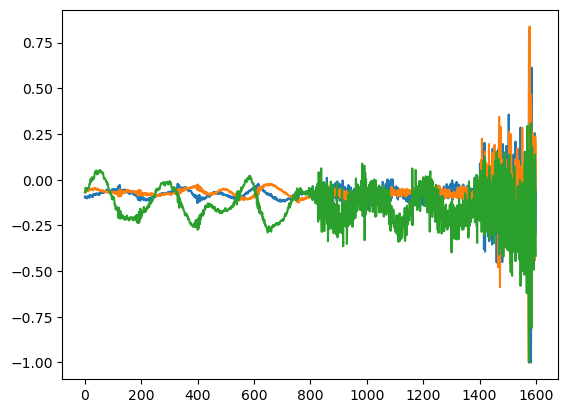

In [16]:
plt.plot(earthquake_data[10,:].T)

In [17]:
np.save("IRIS_earthquake_waveforms_357.npy",earthquake_data)

# Non-Earthquake Signal

In [18]:
client = obspy.clients.fdsn.Client("IRIS")
starttime = "2010-10-31T00:00:00"
endtime = "2012-02-09T23:59:59"
st = obspy.UTCDateTime(starttime)
et = obspy.UTCDateTime(endtime)

noise = []
s=0
while(s<1000):    
    for j in range(len(df)):
        t = df['Origin Time (UTC)'][j].datetime.strftime("%Y-%m-%d %H:%M:%S")
        t1 = obspy.UTCDateTime(t)
        t2 = t1+40
        if st+40<t1:
            overlap=False
        elif st>t2:
            overlap=False
        else:
            overlap=True
            break
        
    if overlap==False:
        wavedata = client.get_waveforms(network="TA",
                            station = "V36A",
                            location = "--",
                            channel = "BH?",
                            starttime=st,
                            endtime=st+40,
                            )
        
        noise2 = np.zeros((3,1600))
        for j in range(3):
            if len(wavedata[j].data)<1600:
                p = list(wavedata[j].data/(abs(wavedata[j].data).max()))
                diff = 1600-len(wavedata[j].data)
                for ii in range(diff):
                    p.append(0)
                noise2[j] = np.array(p)
                
            elif len(wavedata[j].data)>1600:
                noise2[j] = wavedata[j].data[:1600]/(abs(wavedata[j].data[:1600]).max())
            
            else:
                noise2[j] = wavedata[j].data/(abs(wavedata[j].data).max())
                
        noise.append(noise2)
        s+=1
    
    if s%100==0: print("{} non-earthquake samples collected...".format(s))
    st = st+40

noise_data = np.array(noise)
print("Total no. of non-earthquake samples: ",noise_data.shape[0])

100 non-earthquake samples collected...
200 non-earthquake samples collected...
300 non-earthquake samples collected...
400 non-earthquake samples collected...
500 non-earthquake samples collected...
600 non-earthquake samples collected...
700 non-earthquake samples collected...
800 non-earthquake samples collected...
900 non-earthquake samples collected...
1000 non-earthquake samples collected...
Total no. of non-earthquake samples:  1000


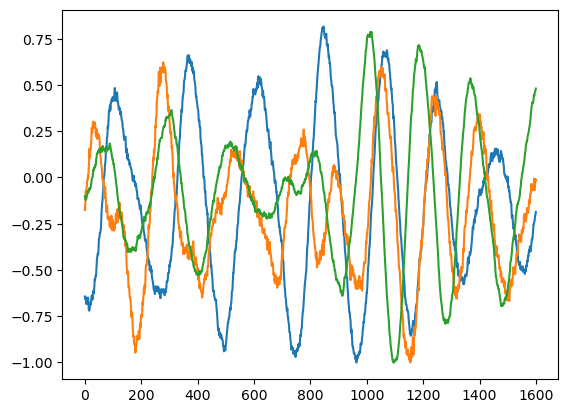

In [20]:
plt.plot(noise_data[800].T)

In [21]:
np.save("IRIS_non_earthquake_waveforms_1000_samples.npy", noise_data)

In [23]:
y_earthquake_data = np.ones((len(df),1))
y_noise_data = np.zeros((len(noise_data),1))
W = np.concatenate([earthquake_data,noise_data], axis=0)
Y = np.concatenate([y_earthquake_data, y_noise_data], axis=0)
W.shape,Y.shape

((1357, 3, 1600), (1357, 1))

In [24]:
seed = 42
np.random.seed(seed)
np.random.shuffle(W)
np.random.seed(seed)
np.random.shuffle(Y)

In [25]:
Y

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

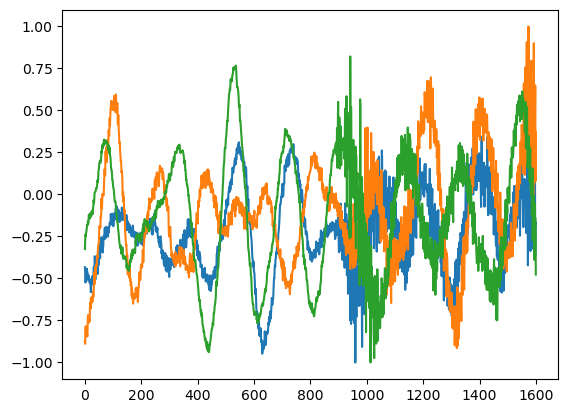

In [26]:
plt.plot(W[0].T)

In [27]:
np.max(earthquake_data), np.min(earthquake_data)

(1.0, -1.0)

In [28]:
np.max(noise_data), np.min(noise_data)

(1.0, -1.0)

In [29]:
W.shape

(1357, 3, 1600)

In [33]:
np.save("IRIS_dataset_waveforms_train.npy", W)
np.save("IRIS_dataset_labels_train.npy",Y)

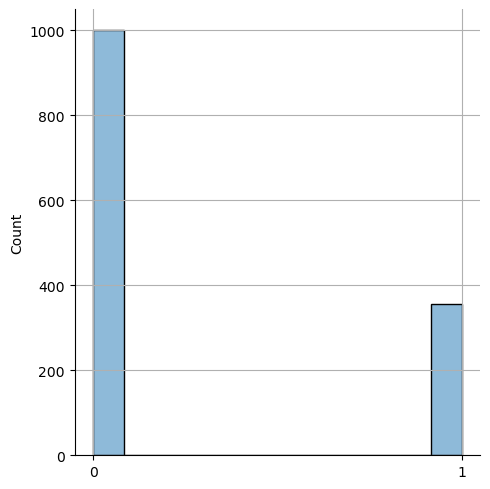

In [36]:
import seaborn as sns
sns.displot(Y,legend=False, kind='hist')
plt.xticks([0,1])
plt.grid()